## Processing of occurrence Data (Cleaning - Removing duplicates

<p style='text-align: justify;'>Removal of duplicated records is very important in occurrence data. Data from the same location may be updated by multiple researchers. In that case, the species are ignored as the duplicate will occur with respect to longitude and latitude. The duplicates can be found out using the following code:</p>

First you need to import required libraries.

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import osmnx as ox, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.ops import cascaded_union

<p style='text-align: justify;'>Next to begin with the processing of data, we need files which contains data. There are two shapefiles which we going to use. One contains data with geometry as points, the file we saved in last page with name - <i>mic_gbif_america.shp</i> and other is going to use as a base for the data containing points as geometry where the base file -<i>TM_WORLD_BORDERS_SIMPL-0.2.shp</i> has geometry as polygons.  </p> 

<p style='text-align: justify;'> Next few process will be done only for SouthAmerica, not for India. Because, gbif has very less number of occurrences species data from India. But Dr. Achuyut Banerjee, partner of my Guide Dr. Amiya Ranjan Bhowmick has collected data of <i>Mikania Micrantha</i> Kunth from Research Institute of India. And processed data has been shared with us. So we will be using the data of India in further work.</p>

The following code help us to understand the role of duplicated data.

Text(156.01243482647544, 0.5, 'Latitude')

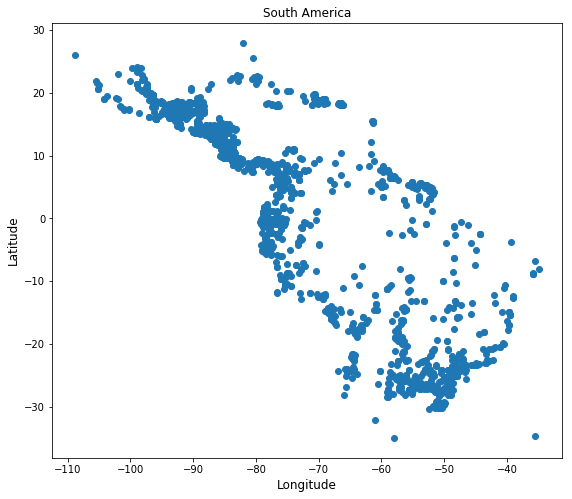

In [2]:
mic_gbif_america=gpd.read_file('mic_gbif_america.shp') 
wrld_simpl=gpd.read_file('TM_WORLD_BORDERS_SIMPL-0.2.shp') 
## duplicated rows of lon-lat columns for South America
dups = mic_gbif_america.duplicated(subset =('lon','lat'))
# total no. of duplicates
sum(dups) 
# dropping duplicated rows
mic_gbif_america = mic_gbif_america.drop_duplicates(subset =('lon','lat'), inplace = False)
mic_gbif_america.plot(figsize=(12,8))
plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)

After removing duplicated rows from data, we will store it in *.shp* file to use the processed data in future.

In [3]:
mic_gbif_america.crs = wrld_simpl.crs
outfp =r"C:\Users\Prajapati Vivek\Desktop\spatial project\mikania\html file\mic_gbif_america.shp"
# Save to disk
mic_gbif_america.to_file(outfp)

Plot of the processed data.

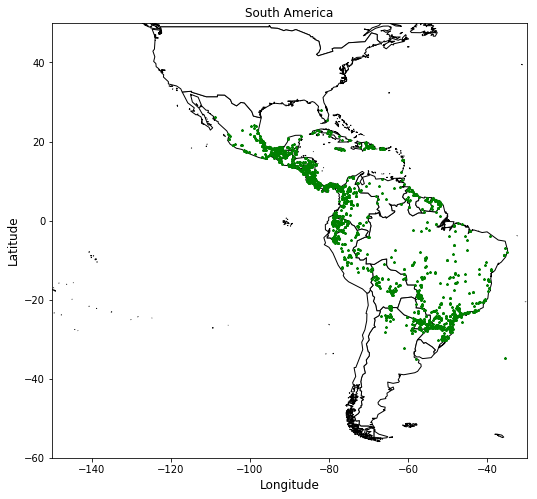

In [4]:
base = wrld_simpl.plot(color ='white', edgecolor ='black',figsize =(12,8)) 
base.set_xlim(-150,-30)
base.set_ylim(-60,50)
plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)
mic_gbif_america.plot(ax=base, marker ='*', color ='green', markersize =5,
figsize =(12,8));

##  Processing of occurrence Data (Cleaning - Points falling on ocean)

<p style='text-align: justify;'>In this section, we remove the occurrence locations that fall into the ocean from the partially cleaned data(after removing the duplicates). Ocean region does not described by polygons, it is actually blank surface in World map. And <code>GeoDataFrame</code> <i>mic_gbif_america</i> contain geometry as points where occurence species is located based on their longitude and latitude values. We combine shapefile with world map data which contains polygons as geometry and <code>GeoDataFrame</code> <i>mic_gbif_america</i> which contains points as geometry, by their spatial join in the following code using module <code>sjoin</code> of library <code>geopandas</code>. The datasets are combined based on their spatial relationship to one another. Two geometry objects are merged based on their spatial relationship to one another. Then the intersection part of polygons and points come out as point data. The method <code>op</code> from module <code>sjoin</code> determines the type of join operation to apply. <code>op</code> can be set to <code>intersects</code>, <code>within</code> or <code>contains</code>. The data is joined based on points to polygons. Here we do not need to clear the data falls in ocean as the following code provides the occurence of data on land. The combined data to be saved in shape file.</p>

Text(156.01243482647544, 0.5, 'Latitude')

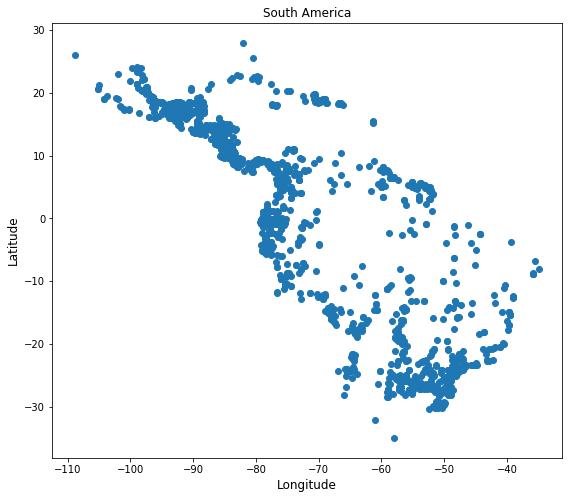

In [5]:
# sjoin a module of geopandas joining data based on spatial relationship.
mic_america_oc = gpd.sjoin(mic_gbif_america, wrld_simpl, how='inner', op='intersects',lsuffix ='left', rsuffix ='right') 
mic_america_oc.crs=from_epsg(4326)
outfp =r"C:\Users\Prajapati Vivek\Desktop\spatial project\mikania\html file\mic_america_oc.shp"
mic_america_oc.to_file(outfp)
mic_america_oc=gpd.read_file('mic_america_oc.shp')
mic_america_oc.plot(figsize=(12,8))
plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)

Plot of the processed data.

Text(75.875, 0.5, 'Latitude')

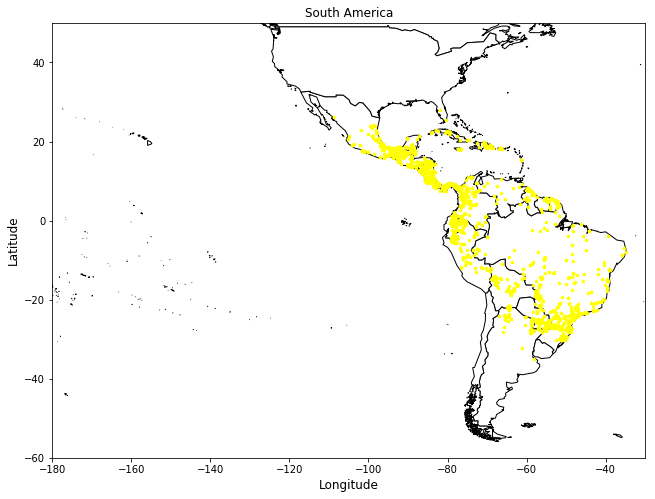

In [6]:
base = wrld_simpl.plot(color ='white', edgecolor ='black', figsize =(12,8))
mic_america_oc.plot(ax=base, marker ='*', color ='yellow', markersize =10, figsize =(12,8))
base.set_xlim(-180,-30)
base.set_ylim(-60,50)
plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)

See the difference on this map and last map. You will find data points to be only on the land surface not on the ocean surface.

## Processing of occurrence Data (Cleaning - geographic bias)

<p style='text-align: justify;'>A critical issue while dealing with the presence-only data is the presence of <b>sample selection bias</b>. It is often observed that the investigator visits the areas for sample collection which are either geographically convenient or environmental-friendly. This gives rise to two different categories of sample selection bias, one occurs in the geographic space and the other in environmental space. For the current <i>Mikania Micrantha</i> data, we shall deal with both types of bias. Using the following piece of code, we shall remove the geographic bias from the sample. The idea is similar to the concept of fishet in ArcGIS. We shall divide the whole region into small grids of a certain resolution and from each grid, we shall select one occurrence point only. The choice of grid size is subjective in nature and will vary for different problems. Note that, we have extended the raster to take care of points that fall within the boundary of the extent we are studying. In code, match the list. Grid cells over the polygons of shape file are collected in this list. From datasets with geometry as points, single points from each grid cell are randomly selected and added it to DataFrame. Points to be noted is that subsampling reduces the number of records, and it cannot correct the data for areas that have not been sampled at all. It suffers from the problem that locally dense records might be a true reflection of the relative suitable of habitat. In first we Plotted all polygons seperately. As South America is a continent it is not a country. All geometry as polygons of South America represent different country located in South America. Next, All polygons have been joined based on their coordinates and single polygon has been created. Basically, it works in the way, that all individual polygons are placed over the plane surface and from that plane surface you are getting the union of all individual polygons that you have placed onto the plane surface. In the following code, this process is done by the method <code>cascaded_union</code> from module <code>ops</code>which is imported from library <code>Shapely</code>. Grid cells are created over the extracted polygon. Whole region is divided into small grid cells. A single occurrence species is collected from each grid cell. Then the data have been saved in shape file with extention <i>.shp</i>.</p>

Here we are interested on the polygon of South America.

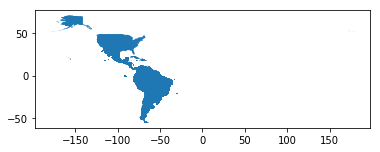

In [7]:
america_with_wrld = gpd.sjoin(wrld_simpl, mic_gbif_america, how='inner', op='intersects') 
america_with_wrld.plot()

The plot is giving intersection part of United States also.

In [8]:
np.unique(america_with_wrld['NAME'])

array(['Argentina', 'Belize', 'Bolivia', 'Brazil', 'Colombia',
       'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'French Guiana', 'Guatemala', 'Guyana', 'Haiti',
       'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay',
       'Peru', 'Puerto Rico', 'Suriname', 'United States', 'Venezuela'],
      dtype=object)

<p style='text-align: justify;'>In this section, our focus is only on SouthAmerica, so we remove the rows containing United States with the following code.</p>

In [9]:
Southamerica=america_with_wrld[(america_with_wrld['NAME']!='United States')]

As you can see in the below plot. On removing <code>'United States'</code> from the column <code>NAME</code> from <code>GeoDataFrame</code>. Plot of only <code>SouthAmerica</code> can be seen.

Text(79.69643683983455, 0.5, 'Latitude')

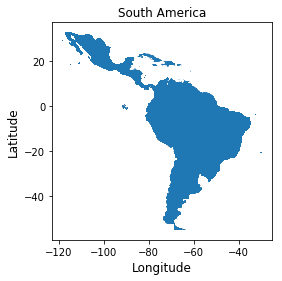

In [10]:
Southamerica.plot()
plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)

<p style='text-align: justify;'>We proceed by giving another name to the <code>SouthAmerica</code>. I will create a copy of </code>South America</code> in another <code>GeoDataFrame</code> and use it in further analysis. One can also use the object <code>SouthAmerica</code>.</p>

In [11]:
amer=Southamerica
length=len(amer)
length

1815

Index have been setup to the data so that in future use, their will not be any problem related to index.

In [12]:
amer=amer.set_index([pd.Index(np.arange(0,length))])
amer.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,index_right,Unnamed_ 0,species,lon,lat
0,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,(POLYGON ((-68.60861199999988 -54.891395999999...,1920,20112,Mikania micrantha,-54.620000,-26.050000
1,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,(POLYGON ((-68.60861199999988 -54.891395999999...,1918,20106,Mikania micrantha,-54.530000,-25.730000
2,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,(POLYGON ((-68.60861199999988 -54.891395999999...,13,777,Mikania micrantha,-54.435917,-25.686639
3,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,(POLYGON ((-68.60861199999988 -54.891395999999...,1877,19365,Mikania micrantha,-54.580000,-25.670000
4,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,(POLYGON ((-68.60861199999988 -54.891395999999...,757,10620,Mikania micrantha,-54.583330,-25.666660


<p style='text-align: justify;'>In the following code, <code>geom</code> is the column <code>geometry</code> in <code>GeoDataFrame</code> with name <code>amer</code>. And there are polygons in all the row of geometry. So <code>isinstance</code> in the code is checking that if values in rows of column <code>geometry</code> is polygon or not. And if the condition satisfies, then Multipolygon will be created using all the Polygons.</p>

In [13]:
geom=amer['geometry']
if isinstance(geom, Polygon):
    geom=MultiPolygon([geom])
#print(geom)

Now creating <code>list</code> of the values in the <code>geometry</code> of <code>amer</code>.

In [14]:
mylist=[]
for i in range(len(amer)):
    g=amer.geometry.values[i]
    mylist.append([g])
#print(mylist)

In [15]:
myGeomList = [x[0] for x in mylist]
#print(myGeomList)

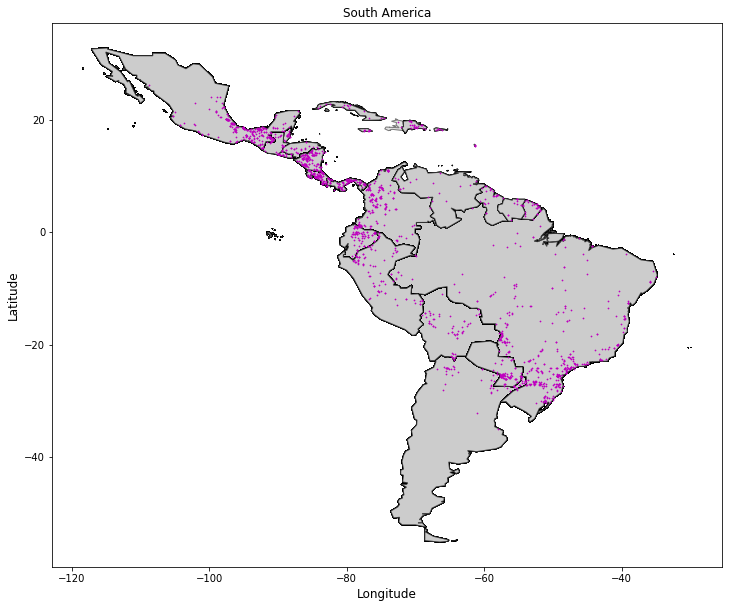

In [16]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(12,10))
for polygon in geom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.3, zorder=1)
    ax.add_patch(patch)
ax.scatter(x=amer['lon'], y=amer['lat'], s=3, c='m', linewidth=0, zorder=2)

ax.axis('on')

plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)
plt.show()

<p style='text-align: justify;'>Using <code>cascaded_union</code> all the polygons will be joined and created as single polygon. As SouthAmerica is not country, it is a continent, it contains total 37 countries. So using <code>cascaded_union</code> polygons of all countries will be joined and form a single polygon.</p>

In [17]:
cu = cascaded_union(myGeomList)

<p style='text-align: justify;'>Using the module <code>quadrat_cut_geometry</code> in library <code>osmnx</code>, gridcells will be created using geometry of joined polygons over the land of SouthAmerica.</p>

In [18]:
geometry_cut = ox.quadrat_cut_geometry(cu, quadrat_width =0.5)
geometry_cut

In [19]:
help(ox.quadrat_cut_geometry)

Help on function quadrat_cut_geometry in module osmnx.core:

quadrat_cut_geometry(geometry, quadrat_width, min_num=3, buffer_amount=1e-09)
    Split a Polygon or MultiPolygon up into sub-polygons of a specified size,
    using quadrats.
    
    Parameters
    ----------
    geometry : shapely Polygon or MultiPolygon
        the geometry to split up into smaller sub-polygons
    quadrat_width : numeric
        the linear width of the quadrats with which to cut up the geometry (in
        the units the geometry is in)
    min_num : int
        the minimum number of linear quadrat lines (e.g., min_num=3 would
        produce a quadrat grid of 4 squares)
    buffer_amount : numeric
        buffer the quadrat grid lines by quadrat_width times buffer_amount
    
    Returns
    -------
    shapely MultiPolygon



### Plot of the gridcells over the SouthAmerica

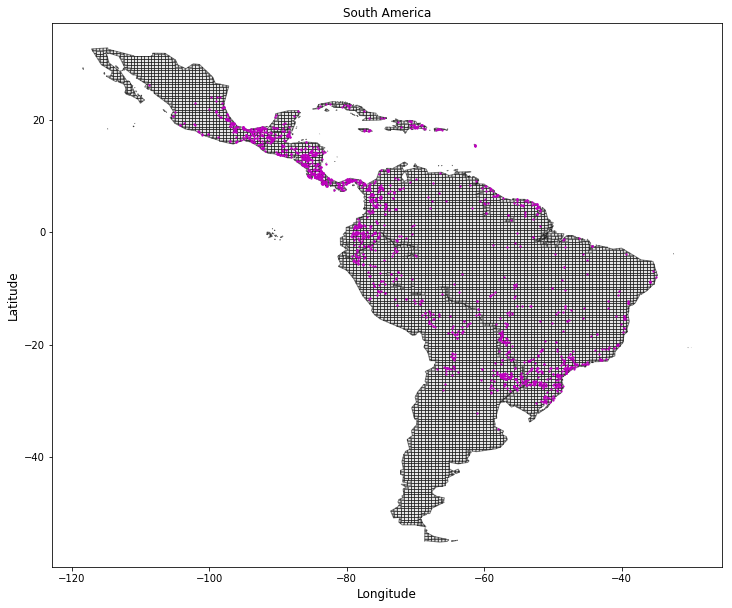

In [20]:
# plot the city with gridcells created on it
fig, ax = plt.subplots(figsize=(12,10))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=1)
    ax.add_patch(patch)
ax.scatter(x=amer['lon'], y=amer['lat'], s=5, c='m', linewidth=0, zorder=2)
    
#ax.set_xlim(west, east)
#ax.set_ylim(south, north)
ax.axis('on')

plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)
plt.show()

Now Using the following codes, list is created from the polygons of all gridcells.

In [21]:
asw=[] # creating list of the polygons of all gridcells.
for polygons in geometry_cut:
    asw.append(polygons)

<p style='text-align: justify;'>Here using module <code>GeoDataFrame</code> of library <code>Geopandas</code>, <code>GeoDataFrame</code> is created of each polygons present in <code>list</code> of the polygons of all gridcells. </p> 

In [22]:
aswd=[] #
for i in range(len(asw)):
    aw=gpd.GeoSeries([asw[i]])
    az=pd.DataFrame({'geometry':aw, 'df':[1]})
    crs={'init': 'epsg:4326'}
    df=gpd.GeoDataFrame(az.df,crs=crs, geometry=az.geometry)
    aswd.append(df)

<p style='text-align: justify;'>Using the module <code>sjoin</code> from library <code>Geopandas</code>, taking out the intersection part of <code>mic_america_oc</code> (data containing Species corresponding to their locations) with each <code>GeoDataFrame</code> created in the <code>list</code> of <code>aswd</code>. Then the <code>list</code> is created for the <code>GeoDataFrame</code> of the intersection part.</p>

In [23]:
qwa=[]
for i in range(len(aswd)):
    mic_america_oc.crs = {'init': 'epsg:4326'}
    qw= gpd.sjoin(mic_america_oc, aswd[i], how='inner', op='intersects')
    qwa.append(qw)

<p style='text-align: justify;'>As you can see in the plot of gridcells. There are occurrence species located inside some of the gridcells and other gridcells has no occurrence species in them. So the <code>present</code> represent list of gridcells which contains species and <code>npresent</code> represent the list of gridcells which does not contain species.</p>

In [24]:
present=[]
npresent=[]
for i in range(len(aswd)):
    if len(qwa[i])==0:
        npresent.append(qwa[i])
    else:
        present.append(qwa[i])
#print(present)      

<p style='text-align: justify;'>There are gridcells which may contain more than one occurrence records. So here our aim is to collect only one occurrence point from the data which would be selected randomly from each gridcell. And then we create a <code>GeoDataFrame</code> of the randomly collected species.</p>

In [25]:
sample=gpd.GeoDataFrame(columns=present[0].columns, crs=wrld_simpl.crs)
for i in range(len(present)):
    ghj=present[i].sample(n=1)
    sample=sample.append(ghj)  

Text(58.02284064924146, 0.5, 'Latitude')

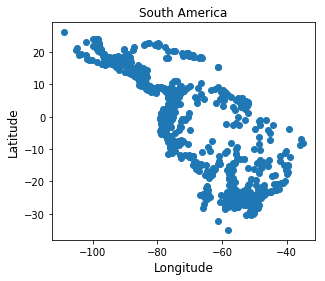

In [26]:
sample.plot()
plt.title('South America', fontsize =12)
plt.xlabel('Longitude', size =12)
plt.ylabel('Latitude', size =12)


<p style='text-align: justify;'><b>Points to be noted is that subsampling reduces the number of records, and it cannot correct the data for areas that have not been sampled at all. It suffers from the problem that locally dense records might be a true reflection of the relative suitable of habitat.</b></p>

In [27]:
len(sample)

765